2023/01/04

# Autoencoder
- 中間層を小さくしつつ出力が入力と同じになるように学習させるニューラルネットワーク
- PCAは線形に分布するときに次元を減らせるが，円状の分布など，非線形な分布ではうまくいかない．
- ニューラルネットワークは中間層を挟むことで任意の非線形な分布を表現できる．
- エンコーダ（入力→圧縮特徴）とデコーダ（圧縮特徴→出力）それぞれに中間層を持つNNを使えば，非線形な次元削減ができる．

In [1]:
# MNISTデータ
from torchvision import transforms, datasets
data = datasets.MNIST("~/data/", transform=transforms.ToTensor(), download=True)

In [6]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, nh, nf) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, nh)
        self.fc2 = nn.Linear(nh, nf)

    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, nh, nf) -> None:
        super().__init__()
        self.fc1 = nn.Linear(nf, nh)
        self.fc2 = nn.Linear(nh, 784)

    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x).sigmoid()
        return x

class AE(nn.Module):
    def __init__(self, nh=64, nf=2) -> None:
        super().__init__()
        self.enc = Encoder(nh, nf)
        self.dec = Decoder(nh, nf)

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [7]:
# 4096ニューロンの中間層を通し，2変数にまで圧縮
ae = AE(4096, 2).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters())
loader = torch.utils.data.DataLoader(data, 128, shuffle=True)

for epoch in range(10):
    for batch, (x, _) in enumerate(loader, 1):
        optimizer.zero_grad()
        x = x.reshape(-1, 784).cuda()
        x_out = ae(x)
        loss = criterion(x_out, x)
        loss.backward()
        optimizer.step()
        print(f"\r[{batch:4d} / {len(loader)} batch] loss: {loss:.4f}", end="")
    print()

[ 469 / 469 batch] loss: 0.0428
[ 469 / 469 batch] loss: 0.0401
[ 469 / 469 batch] loss: 0.0406
[ 469 / 469 batch] loss: 0.0428
[ 469 / 469 batch] loss: 0.0443
[ 469 / 469 batch] loss: 0.0432
[ 469 / 469 batch] loss: 0.0405
[ 469 / 469 batch] loss: 0.0398
[ 469 / 469 batch] loss: 0.0411
[ 469 / 469 batch] loss: 0.0385


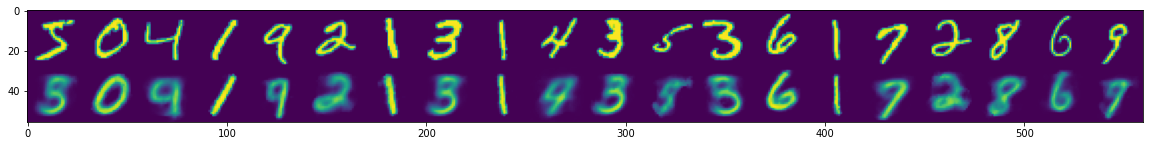

In [8]:
# AEを通した画像を確認．4, 7, 9あたりが怪しい
import numpy as np
import matplotlib.pyplot as plt
x = (data.data[:20]/255).reshape(-1, 784)
x_ae = ae(x.cuda()).cpu().detach().numpy()
plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(np.c_[x, x_ae].reshape(-1, 56, 28)))

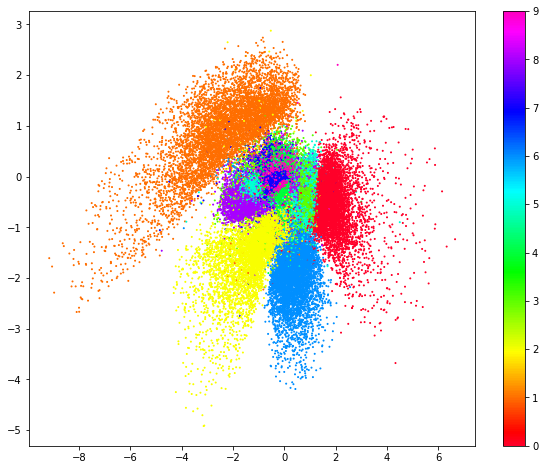

In [9]:
# エンコードされた特徴量の分布
x, y = data._load_data()
x = (x/255).reshape(-1, 784)
z = ae.enc(x.cuda()).cpu().detach().numpy()

plt.figure(figsize=(10, 8))
plt.scatter(*z.T, 1, y, cmap="gist_rainbow")
plt.colorbar()

3変数ならどうか

In [10]:
ae = AE(4096, 3).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters())
loader = torch.utils.data.DataLoader(data, 128, shuffle=True)

for epoch in range(10):
    for batch, (x, _) in enumerate(loader, 1):
        optimizer.zero_grad()
        x = x.reshape(-1, 784).cuda()
        x_out = ae(x)
        loss = criterion(x_out, x)
        loss.backward()
        optimizer.step()
        print(f"\r[{batch:4d} / {len(loader)} batch] loss: {loss:.4f}", end="")
    print()

[ 469 / 469 batch] loss: 0.0408
[ 469 / 469 batch] loss: 0.0372
[ 469 / 469 batch] loss: 0.0360
[ 469 / 469 batch] loss: 0.0357
[ 469 / 469 batch] loss: 0.0367
[ 469 / 469 batch] loss: 0.0347
[ 469 / 469 batch] loss: 0.0331
[ 469 / 469 batch] loss: 0.0318
[ 469 / 469 batch] loss: 0.0313
[ 469 / 469 batch] loss: 0.0359


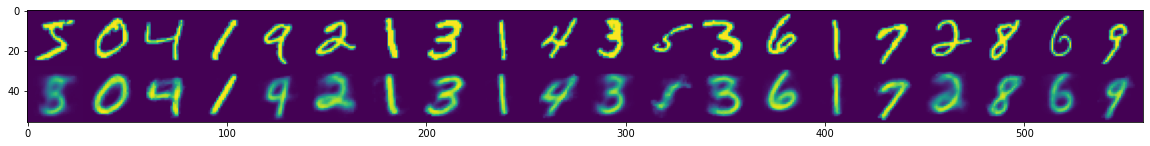

In [11]:
# だいぶ改善．5は逆にちょっと怪しくなった．
x = (data.data[:20]/255).reshape(-1, 784)
x_ae = ae(x.cuda()).cpu().detach().numpy()
plt.figure(figsize=(20, 5))
plt.imshow(np.hstack(np.c_[x, x_ae].reshape(-1, 56, 28)))

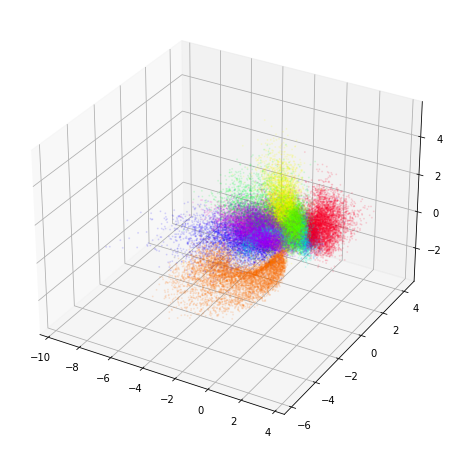

In [24]:
# エンコードされた特徴量の分布
x, y = data._load_data()
x = (x/255).reshape(-1, 784)
z = ae.enc(x.cuda()).cpu().detach().numpy()

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="3d")
ax.scatter(*z.T, s=1, c=y, alpha=0.1, cmap="gist_rainbow")

PCAで画像圧縮はさすがに厳しい

In [174]:
from sklearn.decomposition import PCA
pca = PCA(5).fit(x)
x_pca = pca.transform(x)

In [177]:
# 累積寄与率は5変数で33%程度
pca.explained_variance_ratio_.cumsum()

array([0.09704664, 0.16800588, 0.22969677, 0.28359097, 0.33227894])

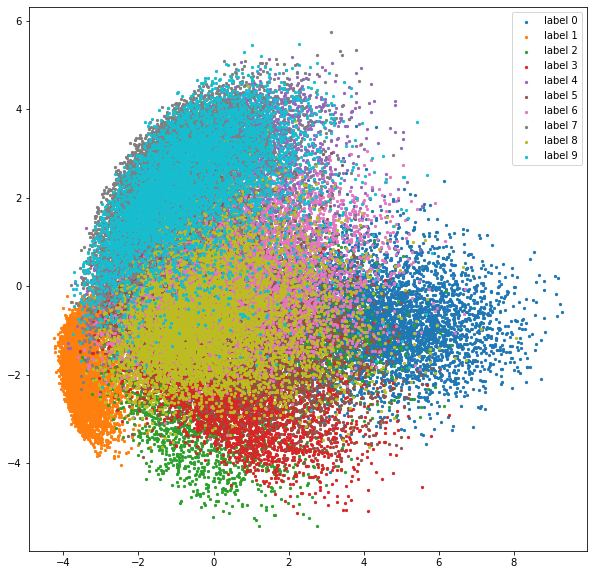

In [178]:
plt.figure(figsize=(10, 10))
for label in range(10):
    plt.scatter(x_pca[y==label, 0], x_pca[y==label, 1], 5, label=f"label {label}")
plt.legend()